trying to increase the layers so that the model is more similar to Anna Green's model.

In [1]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [3]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

### Loading data

In [4]:
train_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/gene_seq_train.csv')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC/data0/res_train.csv')

train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/res_train.csv')
#don't touch test data, split out validation data from training data during training
test_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/gene_seq_test.csv')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC/data0/res_test.csv')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/res_test.csv')

In [5]:
from sklearn.preprocessing import StandardScaler
def normalize_dataframe(df):
    """
    Normalize the given DataFrame column-wise while keeping NaN values unchanged.

    :param df: Pandas DataFrame to be normalized.
    :return: Normalized DataFrame.
    """
    scaler = StandardScaler()
    for column in df.columns:
        # Extract the non-NaN values and their indices
        non_nan_values = df[column].dropna()
        indices = non_nan_values.index
        
        # Normalize the non-NaN values
        normalized_values = scaler.fit_transform(non_nan_values.values.reshape(-1, 1)).flatten()
        
        # Assign the normalized values back to the DataFrame
        df.loc[indices, column] = normalized_values
    
    return df

# train_target = normalize_dataframe(train_target)


In [6]:
N_samples = train_data.shape[0]
DRUGS = ['AMIKACIN',
 'CAPREOMYCIN',
 'CIPROFLOXACIN',
 'ETHAMBUTOL',
 'ETHIONAMIDE',
 'ISONIAZID',
 'KANAMYCIN',
 'LEVOFLOXACIN',
 'MOXIFLOXACIN',
 'OFLOXACIN',
 'PYRAZINAMIDE',
 'RIFAMPICIN',
 'STREPTOMYCIN']

DRUGS = train_target.columns
LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)

# Feature engineering

In [7]:
def one_hot_torch(seq: str, dtype=torch.int8):
    seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
    acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
    arr = torch.zeros(4, (len(seq_bytes)), dtype=dtype)
    arr[0, seq_bytes == acgt_bytes[0]] = 1
    arr[1, seq_bytes == acgt_bytes[1]] = 1
    arr[2, seq_bytes == acgt_bytes[2]] = 1
    arr[3, seq_bytes == acgt_bytes[3]] = 1
    return arr

# def one_hot_torch(seq):
#     oh = []
#     for sample in seq:
#         sample = torch.ByteTensor(list(bytes(sample, "utf-8")))
#         acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#         arr = torch.zeros((len(sample), 4), dtype=torch.int8)
#         arr[sample == acgt_bytes[0], 0] = 1
#         arr[sample == acgt_bytes[1], 1] = 1
#         arr[sample == acgt_bytes[2], 2] = 1
#         arr[sample == acgt_bytes[3], 3] = 1
#         oh.append(arr)
#     return torch.stack(oh)

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


def get_masked_loss(loss_fn):
    """
    Returns a loss function that ignores NaN values
    """

    def masked_loss(y_true, y_pred):
        y_pred = y_pred.view(-1, 13)  # Ensure y_pred has the same shape as y_true and non_nan_mask
        # ic(y_pred.shape)
        # ic(y_true.shape)
        non_nan_mask = ~y_true.isnan()
        # ic(non_nan_mask)
        y_true_non_nan = y_true[non_nan_mask]
        y_pred_non_nan = y_pred[non_nan_mask]

        return loss_fn(y_pred_non_nan, y_true_non_nan)

    return masked_loss

masked_MSE = get_masked_loss(torch.nn.MSELoss())

# Dateset

In [8]:
class OneHotSeqsDataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        self.seq_df = seq_df[target_loci]
        self.res_df = res_df[target_drugs]
        if not self.seq_df.index.equals(self.res_df.index):
            raise ValueError(
                "Indices of sequence and resistance dataframes don't match up"
            )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_df.iloc[index].str.cat()
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df.loc[index].str.cat()
            res = self.res_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return one_hot_torch(seqs_comb, dtype=self.one_hot_dtype), torch.tensor(res)

    def __len__(self):
        return self.res_df.shape[0]

training_dataset = OneHotSeqsDataset(train_data, train_target, one_hot_dtype=torch.float, transform=True)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

In [9]:
for x, y in train_dataset:
    print(x)
    print(y)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([-2.0794, -5.5215, -4.1997, -5.5215, -2.0794, -2.0794, -4.4874, -0.6931,
        -2.8134, -3.5066, -3.5066, -4.1997, -3.5066], dtype=torch.float64)


# Model

In [10]:
def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")

In [20]:
torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=4,
        num_classes=1,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        self.feature_extraction_layer = self._conv_layer(
            in_channels, num_filters, filter_length
        )
        
        #dynamic filter scaling from deepram
        current_num_filters = num_filters
        
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters, int(current_num_filters * filter_scaling_factor), 12)
            self.conv_layers1.append(layer)
            current_num_filters = int(current_num_filters * filter_scaling_factor)

        self.conv_layers2 = nn.ModuleList()
        for i in range(2):
            layer = self._conv_layer(current_num_filters, int(current_num_filters * filter_scaling_factor), 12)
            self.conv_layers2.append(layer)
            current_num_filters = int(current_num_filters * filter_scaling_factor)

        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [current_num_filters]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        
        # self.dense_layers = nn.ModuleList(
        #     self._dense_layer(input_dim, num_dense_neurons)
        #     for input_dim in [current_num_filters]
        #     + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        # )
        
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.maxpool = nn.MaxPool2d(3, stride=1)
        
        self.apply(self.init_weights)    
        
        
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    def forward(self, x):
        # first pass over input
        # print(x.size())
        x = self.feature_extraction_layer(x)
        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        # x = torch.max(x, dim=-1).values
        # x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        ic(x.size())
        x = self.maxpool(x)
        
        ic(x.size())
        
        for layer in self.conv_layers2:
            x = layer(x)
        ic(x.size())
            
        x = self.maxpool(x)
        ic(x.size())
        
        # ic(x.shape)
        # fully connected layers
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        ic(x.size())
        
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=1,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=1,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 10  # How many epochs to wait after last time validation loss improved.
patience_counter = 0



epoch = 250
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-4

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
criterion = masked_MSE
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

In [21]:
from torchsummary import summary
summary(model, (4, 56850))


ic| x.size(): torch.Size([2, 64, 56815])
ic| x.size(): torch.Size([2, 62, 56813])


RuntimeError: Given groups=1, weight of size [64, 64, 12], expected input[2, 62, 56813] to have 64 channels, but got 62 channels instead

# Training

### Training

In [13]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []



for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        # y_batch = y_batch.view(-1)
        # y_batch = one_hot_torch(y).to(device)
        # print('batch y size before flatten:',y_batch.size())
        # y_batch = y_batch.flatten()
        # print('batch y size after flatten:',y_batch.size())
        # print(x_batch.size())
        # print(x_batch.size())
    # For example, if you have a convolutional layer with 64 output channels, 3 input channels, and a kernel size of 3x3, the weight parameters would have a dimension of (64, 3, 3, 3)
        # print(x_batch.size())
        pred = model(x_batch.float())
        # print('y_batch')
        # print(y_batch)
        # print('pred')
        # print(pred)
        # pred = pred.unsqueeze(0)
        # ic(pred)
        # ic(y_batch)
        ic(pred.size())
        loss_train = criterion(y_batch, pred)
        # print('loss_train')
        # print(loss_train)
        train_batch_loss.append(loss_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.float().to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            # pred = pred.unsqueeze(0)

            loss_test = criterion(y_batch, pred)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    #! implementing early stopping
    current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    print(f'Current val loss: {current_val_loss}')
    print(f'Best val loss: {best_val_loss}')
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0  # reset patience counter
        # Save the best model
        # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            torch.save({
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
        }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_final1.pth')
            break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'training_final1' ,epoch, lr=1e-4, fc_dr=0.2, l2=1e-9, train_loss = train_epoch_loss, test_loss = test_epoch_loss)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_final1.png')
print(f'./graphs1/loss_lr_{lr}_final1.png')

# torch.save({
#     'optimizer': optimizer.state_dict(),
#     'model': model.state_dict(),
# }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

  0%|          | 1/250 [00:59<4:08:04, 59.78s/it]

Epoch 1
Training loss: 4.988264560699463
Validation loss: 4.333120346069336
Current val loss: 4.333120346069336
Best val loss: inf


  1%|          | 2/250 [01:58<4:04:45, 59.22s/it]

Epoch 2
Training loss: 3.7572221755981445
Validation loss: 3.7874393463134766
Current val loss: 3.7874393463134766
Best val loss: 4.333120346069336


  1%|          | 3/250 [02:57<4:02:30, 58.91s/it]

Epoch 3
Training loss: 3.0997262001037598
Validation loss: 3.3925602436065674
Current val loss: 3.3925602436065674
Best val loss: 3.7874393463134766


  2%|▏         | 4/250 [03:55<4:00:43, 58.71s/it]

Epoch 4
Training loss: 2.7588436603546143
Validation loss: 3.1348371505737305
Current val loss: 3.1348371505737305
Best val loss: 3.3925602436065674


  2%|▏         | 5/250 [04:54<3:59:39, 58.69s/it]

Epoch 5
Training loss: 2.5757429599761963
Validation loss: 2.9125070571899414
Current val loss: 2.9125070571899414
Best val loss: 3.1348371505737305


  2%|▏         | 6/250 [05:52<3:58:08, 58.56s/it]

Epoch 6
Training loss: 2.47212815284729
Validation loss: 2.7735466957092285
Current val loss: 2.7735466957092285
Best val loss: 2.9125070571899414


  3%|▎         | 7/250 [06:50<3:56:50, 58.48s/it]

Epoch 7
Training loss: 2.4208927154541016
Validation loss: 2.6481802463531494
Current val loss: 2.6481802463531494
Best val loss: 2.7735466957092285


  3%|▎         | 8/250 [07:49<3:55:39, 58.43s/it]

Epoch 8
Training loss: 2.3982527256011963
Validation loss: 2.5471696853637695
Current val loss: 2.5471696853637695
Best val loss: 2.6481802463531494


  4%|▎         | 9/250 [08:47<3:54:37, 58.41s/it]

Epoch 9
Training loss: 2.3607730865478516
Validation loss: 2.494853973388672
Current val loss: 2.494853973388672
Best val loss: 2.5471696853637695


  4%|▍         | 10/250 [09:45<3:53:24, 58.35s/it]

Epoch 10
Training loss: 2.3439981937408447
Validation loss: 2.447114944458008
Current val loss: 2.447114944458008
Best val loss: 2.494853973388672


  4%|▍         | 11/250 [10:44<3:52:25, 58.35s/it]

Epoch 11
Training loss: 2.326813220977783
Validation loss: 2.430324077606201
Current val loss: 2.430324077606201
Best val loss: 2.447114944458008


  5%|▍         | 12/250 [11:42<3:51:13, 58.29s/it]

Epoch 12
Training loss: 2.3055078983306885
Validation loss: 2.35713529586792
Current val loss: 2.35713529586792
Best val loss: 2.430324077606201


  5%|▌         | 13/250 [12:40<3:50:11, 58.28s/it]

Epoch 13
Training loss: 2.2821311950683594
Validation loss: 2.340672731399536
Current val loss: 2.340672731399536
Best val loss: 2.35713529586792


  6%|▌         | 14/250 [13:38<3:48:59, 58.22s/it]

Epoch 14
Training loss: 2.2561163902282715
Validation loss: 2.2940287590026855
Current val loss: 2.2940287590026855
Best val loss: 2.340672731399536


  6%|▌         | 15/250 [14:36<3:47:50, 58.17s/it]

Epoch 15
Training loss: 2.2034988403320312
Validation loss: 2.2153658866882324
Current val loss: 2.2153658866882324
Best val loss: 2.2940287590026855


  6%|▋         | 16/250 [15:34<3:46:56, 58.19s/it]

Epoch 16
Training loss: 2.1098551750183105
Validation loss: 2.0552008152008057
Current val loss: 2.0552008152008057
Best val loss: 2.2153658866882324


  7%|▋         | 17/250 [16:32<3:45:52, 58.16s/it]

Epoch 17
Training loss: 2.0221405029296875
Validation loss: 1.8976894617080688
Current val loss: 1.8976894617080688
Best val loss: 2.0552008152008057


  7%|▋         | 18/250 [17:31<3:45:00, 58.19s/it]

Epoch 18
Training loss: 1.9706209897994995
Validation loss: 1.805314302444458
Current val loss: 1.805314302444458
Best val loss: 1.8976894617080688


  8%|▊         | 19/250 [18:29<3:44:19, 58.27s/it]

Epoch 19
Training loss: 1.9354071617126465
Validation loss: 1.7633968591690063
Current val loss: 1.7633968591690063
Best val loss: 1.805314302444458


  8%|▊         | 20/250 [19:28<3:43:42, 58.36s/it]

Epoch 20
Training loss: 1.886275291442871
Validation loss: 1.7297453880310059
Current val loss: 1.7297453880310059
Best val loss: 1.7633968591690063


  8%|▊         | 21/250 [20:26<3:42:29, 58.30s/it]

Epoch 21
Training loss: 1.8402774333953857
Validation loss: 1.676571249961853
Current val loss: 1.676571249961853
Best val loss: 1.7297453880310059


  9%|▉         | 22/250 [21:24<3:41:30, 58.29s/it]

Epoch 22
Training loss: 1.8089981079101562
Validation loss: 1.6255316734313965
Current val loss: 1.6255316734313965
Best val loss: 1.676571249961853


  9%|▉         | 23/250 [22:22<3:40:15, 58.22s/it]

Epoch 23
Training loss: 1.7857091426849365
Validation loss: 1.6264253854751587
Current val loss: 1.6264253854751587
Best val loss: 1.6255316734313965


 10%|▉         | 24/250 [23:20<3:39:12, 58.19s/it]

Epoch 24
Training loss: 1.7511264085769653
Validation loss: 1.5745089054107666
Current val loss: 1.5745089054107666
Best val loss: 1.6255316734313965


 10%|█         | 25/250 [24:18<3:38:10, 58.18s/it]

Epoch 25
Training loss: 1.7235721349716187
Validation loss: 1.5377869606018066
Current val loss: 1.5377869606018066
Best val loss: 1.5745089054107666


 10%|█         | 26/250 [25:17<3:37:30, 58.26s/it]

Epoch 26
Training loss: 1.6786431074142456
Validation loss: 1.5036178827285767
Current val loss: 1.5036178827285767
Best val loss: 1.5377869606018066


 11%|█         | 27/250 [26:15<3:36:26, 58.24s/it]

Epoch 27
Training loss: 1.6455893516540527
Validation loss: 1.465163230895996
Current val loss: 1.465163230895996
Best val loss: 1.5036178827285767


 11%|█         | 28/250 [27:13<3:35:16, 58.18s/it]

Epoch 28
Training loss: 1.5898911952972412
Validation loss: 1.3798167705535889
Current val loss: 1.3798167705535889
Best val loss: 1.465163230895996


 12%|█▏        | 29/250 [28:11<3:34:13, 58.16s/it]

Epoch 29
Training loss: 1.540360689163208
Validation loss: 1.3319199085235596
Current val loss: 1.3319199085235596
Best val loss: 1.3798167705535889


 12%|█▏        | 30/250 [29:09<3:33:14, 58.16s/it]

Epoch 30
Training loss: 1.487296462059021
Validation loss: 1.284205675125122
Current val loss: 1.284205675125122
Best val loss: 1.3319199085235596


 12%|█▏        | 31/250 [30:08<3:32:12, 58.14s/it]

Epoch 31
Training loss: 1.4459359645843506
Validation loss: 1.2640671730041504
Current val loss: 1.2640671730041504
Best val loss: 1.284205675125122


 13%|█▎        | 32/250 [31:06<3:31:14, 58.14s/it]

Epoch 32
Training loss: 1.4217431545257568
Validation loss: 1.2599267959594727
Current val loss: 1.2599267959594727
Best val loss: 1.2640671730041504


 13%|█▎        | 33/250 [32:04<3:30:14, 58.13s/it]

Epoch 33
Training loss: 1.4035887718200684
Validation loss: 1.2403557300567627
Current val loss: 1.2403557300567627
Best val loss: 1.2599267959594727


 14%|█▎        | 34/250 [33:02<3:29:23, 58.16s/it]

Epoch 34
Training loss: 1.3705881834030151
Validation loss: 1.216085433959961
Current val loss: 1.216085433959961
Best val loss: 1.2403557300567627


 14%|█▍        | 35/250 [34:00<3:28:24, 58.16s/it]

Epoch 35
Training loss: 1.3648581504821777
Validation loss: 1.226932406425476
Current val loss: 1.226932406425476
Best val loss: 1.216085433959961


 14%|█▍        | 36/250 [34:59<3:27:52, 58.28s/it]

Epoch 36
Training loss: 1.3337323665618896
Validation loss: 1.1969163417816162
Current val loss: 1.1969163417816162
Best val loss: 1.216085433959961


 15%|█▍        | 37/250 [35:57<3:27:04, 58.33s/it]

Epoch 37
Training loss: 1.3080518245697021
Validation loss: 1.2217334508895874
Current val loss: 1.2217334508895874
Best val loss: 1.1969163417816162


 15%|█▌        | 38/250 [36:56<3:26:09, 58.35s/it]

Epoch 38
Training loss: 1.280334711074829
Validation loss: 1.191495418548584
Current val loss: 1.191495418548584
Best val loss: 1.1969163417816162


 16%|█▌        | 39/250 [37:54<3:25:21, 58.40s/it]

Epoch 39
Training loss: 1.2749896049499512
Validation loss: 1.1506474018096924
Current val loss: 1.1506474018096924
Best val loss: 1.191495418548584


 16%|█▌        | 40/250 [38:52<3:24:23, 58.40s/it]

Epoch 40
Training loss: 1.2471072673797607
Validation loss: 1.1572707891464233
Current val loss: 1.1572707891464233
Best val loss: 1.1506474018096924


 16%|█▋        | 41/250 [39:51<3:23:18, 58.36s/it]

Epoch 41
Training loss: 1.2370797395706177
Validation loss: 1.1396138668060303
Current val loss: 1.1396138668060303
Best val loss: 1.1506474018096924


 17%|█▋        | 42/250 [40:49<3:22:17, 58.35s/it]

Epoch 42
Training loss: 1.2246649265289307
Validation loss: 1.1304008960723877
Current val loss: 1.1304008960723877
Best val loss: 1.1396138668060303


 17%|█▋        | 43/250 [41:48<3:21:35, 58.43s/it]

Epoch 43
Training loss: 1.2078332901000977
Validation loss: 1.133994221687317
Current val loss: 1.133994221687317
Best val loss: 1.1304008960723877


 18%|█▊        | 44/250 [42:46<3:20:41, 58.45s/it]

Epoch 44
Training loss: 1.2028758525848389
Validation loss: 1.1363444328308105
Current val loss: 1.1363444328308105
Best val loss: 1.1304008960723877


 18%|█▊        | 45/250 [43:45<3:19:33, 58.41s/it]

Epoch 45
Training loss: 1.1924573183059692
Validation loss: 1.1007568836212158
Current val loss: 1.1007568836212158
Best val loss: 1.1304008960723877


 18%|█▊        | 46/250 [44:43<3:18:19, 58.33s/it]

Epoch 46
Training loss: 1.1909399032592773
Validation loss: 1.122450828552246
Current val loss: 1.122450828552246
Best val loss: 1.1007568836212158


 19%|█▉        | 47/250 [45:41<3:17:26, 58.36s/it]

Epoch 47
Training loss: 1.1709414720535278
Validation loss: 1.1096203327178955
Current val loss: 1.1096203327178955
Best val loss: 1.1007568836212158


 19%|█▉        | 48/250 [46:40<3:16:35, 58.39s/it]

Epoch 48
Training loss: 1.165332555770874
Validation loss: 1.087404489517212
Current val loss: 1.087404489517212
Best val loss: 1.1007568836212158


 20%|█▉        | 49/250 [47:38<3:15:40, 58.41s/it]

Epoch 49
Training loss: 1.1579108238220215
Validation loss: 1.0831263065338135
Current val loss: 1.0831263065338135
Best val loss: 1.087404489517212


 20%|██        | 50/250 [48:36<3:14:39, 58.40s/it]

Epoch 50
Training loss: 1.1461929082870483
Validation loss: 1.0799332857131958
Current val loss: 1.0799332857131958
Best val loss: 1.0831263065338135


 20%|██        | 51/250 [49:35<3:13:24, 58.31s/it]

Epoch 51
Training loss: 1.1157331466674805
Validation loss: 1.0607740879058838
Current val loss: 1.0607740879058838
Best val loss: 1.0799332857131958


 21%|██        | 52/250 [50:33<3:12:10, 58.23s/it]

Epoch 52
Training loss: 1.1202328205108643
Validation loss: 1.0461390018463135
Current val loss: 1.0461390018463135
Best val loss: 1.0607740879058838


 21%|██        | 53/250 [51:31<3:11:07, 58.21s/it]

Epoch 53
Training loss: 1.1215035915374756
Validation loss: 1.0401841402053833
Current val loss: 1.0401841402053833
Best val loss: 1.0461390018463135


 22%|██▏       | 54/250 [52:29<3:10:20, 58.27s/it]

Epoch 54
Training loss: 1.1072252988815308
Validation loss: 1.028294324874878
Current val loss: 1.028294324874878
Best val loss: 1.0401841402053833


 22%|██▏       | 55/250 [53:27<3:09:11, 58.21s/it]

Epoch 55
Training loss: 1.0984017848968506
Validation loss: 1.0295161008834839
Current val loss: 1.0295161008834839
Best val loss: 1.028294324874878


 22%|██▏       | 56/250 [54:26<3:08:22, 58.26s/it]

Epoch 56
Training loss: 1.091274619102478
Validation loss: 1.0175261497497559
Current val loss: 1.0175261497497559
Best val loss: 1.028294324874878


 23%|██▎       | 57/250 [55:24<3:07:26, 58.27s/it]

Epoch 57
Training loss: 1.091212511062622
Validation loss: 1.0007985830307007
Current val loss: 1.0007985830307007
Best val loss: 1.0175261497497559


 23%|██▎       | 58/250 [56:22<3:06:24, 58.25s/it]

Epoch 58
Training loss: 1.0743144750595093
Validation loss: 1.0143157243728638
Current val loss: 1.0143157243728638
Best val loss: 1.0007985830307007


 24%|██▎       | 59/250 [57:20<3:05:19, 58.22s/it]

Epoch 59
Training loss: 1.0812809467315674
Validation loss: 1.0059237480163574
Current val loss: 1.0059237480163574
Best val loss: 1.0007985830307007


 24%|██▍       | 60/250 [58:18<3:04:21, 58.22s/it]

Epoch 60
Training loss: 1.0714884996414185
Validation loss: 0.9934769868850708
Current val loss: 0.9934769868850708
Best val loss: 1.0007985830307007


 24%|██▍       | 61/250 [59:17<3:03:26, 58.24s/it]

Epoch 61
Training loss: 1.063179612159729
Validation loss: 0.9929711818695068
Current val loss: 0.9929711818695068
Best val loss: 0.9934769868850708


 25%|██▍       | 62/250 [1:00:15<3:02:17, 58.18s/it]

Epoch 62
Training loss: 1.0630507469177246
Validation loss: 0.9976683855056763
Current val loss: 0.9976683855056763
Best val loss: 0.9929711818695068


 25%|██▌       | 63/250 [1:01:13<3:01:36, 58.27s/it]

Epoch 63
Training loss: 1.050351858139038
Validation loss: 0.9759358167648315
Current val loss: 0.9759358167648315
Best val loss: 0.9929711818695068


 26%|██▌       | 64/250 [1:02:12<3:00:39, 58.27s/it]

Epoch 64
Training loss: 1.0566887855529785
Validation loss: 0.984043538570404
Current val loss: 0.984043538570404
Best val loss: 0.9759358167648315


 26%|██▌       | 65/250 [1:03:10<2:59:37, 58.26s/it]

Epoch 65
Training loss: 1.0467796325683594
Validation loss: 0.9970542788505554
Current val loss: 0.9970542788505554
Best val loss: 0.9759358167648315


 26%|██▋       | 66/250 [1:04:08<2:58:33, 58.23s/it]

Epoch 66
Training loss: 1.0441794395446777
Validation loss: 0.9748585224151611
Current val loss: 0.9748585224151611
Best val loss: 0.9759358167648315


 27%|██▋       | 67/250 [1:05:06<2:57:33, 58.21s/it]

Epoch 67
Training loss: 1.0428411960601807
Validation loss: 0.9773572683334351
Current val loss: 0.9773572683334351
Best val loss: 0.9748585224151611


 27%|██▋       | 68/250 [1:06:04<2:56:38, 58.23s/it]

Epoch 68
Training loss: 1.032789707183838
Validation loss: 0.9791557192802429
Current val loss: 0.9791557192802429
Best val loss: 0.9748585224151611


 28%|██▊       | 69/250 [1:07:03<2:55:55, 58.32s/it]

Epoch 69
Training loss: 1.0220133066177368
Validation loss: 0.959693431854248
Current val loss: 0.959693431854248
Best val loss: 0.9748585224151611


 28%|██▊       | 70/250 [1:08:01<2:55:04, 58.36s/it]

Epoch 70
Training loss: 1.0122506618499756
Validation loss: 0.9566732048988342
Current val loss: 0.9566732048988342
Best val loss: 0.959693431854248


 28%|██▊       | 71/250 [1:09:00<2:53:59, 58.32s/it]

Epoch 71
Training loss: 1.0200444459915161
Validation loss: 0.9635626077651978
Current val loss: 0.9635626077651978
Best val loss: 0.9566732048988342


 29%|██▉       | 72/250 [1:09:58<2:53:09, 58.37s/it]

Epoch 72
Training loss: 1.018088936805725
Validation loss: 0.975295901298523
Current val loss: 0.975295901298523
Best val loss: 0.9566732048988342


 29%|██▉       | 73/250 [1:10:56<2:52:07, 58.35s/it]

Epoch 73
Training loss: 1.0138972997665405
Validation loss: 0.9494810700416565
Current val loss: 0.9494810700416565
Best val loss: 0.9566732048988342


 30%|██▉       | 74/250 [1:11:55<2:51:18, 58.40s/it]

Epoch 74
Training loss: 1.0114713907241821
Validation loss: 0.9446799159049988
Current val loss: 0.9446799159049988
Best val loss: 0.9494810700416565


 30%|███       | 75/250 [1:12:53<2:50:18, 58.39s/it]

Epoch 75
Training loss: 1.003203272819519
Validation loss: 0.9463571310043335
Current val loss: 0.9463571310043335
Best val loss: 0.9446799159049988


 30%|███       | 76/250 [1:13:52<2:49:16, 58.37s/it]

Epoch 76
Training loss: 0.9971848726272583
Validation loss: 0.9518428444862366
Current val loss: 0.9518428444862366
Best val loss: 0.9446799159049988


 31%|███       | 77/250 [1:14:50<2:48:03, 58.29s/it]

Epoch 77
Training loss: 1.0036275386810303
Validation loss: 0.9566763639450073
Current val loss: 0.9566763639450073
Best val loss: 0.9446799159049988


 31%|███       | 78/250 [1:15:48<2:47:09, 58.31s/it]

Epoch 78
Training loss: 0.9947186708450317
Validation loss: 0.9330195188522339
Current val loss: 0.9330195188522339
Best val loss: 0.9446799159049988


 32%|███▏      | 79/250 [1:16:46<2:46:19, 58.36s/it]

Epoch 79
Training loss: 0.9890596270561218
Validation loss: 0.9275685548782349
Current val loss: 0.9275685548782349
Best val loss: 0.9330195188522339


 32%|███▏      | 80/250 [1:17:45<2:45:19, 58.35s/it]

Epoch 80
Training loss: 0.9794255495071411
Validation loss: 0.9237344264984131
Current val loss: 0.9237344264984131
Best val loss: 0.9275685548782349


 32%|███▏      | 81/250 [1:18:43<2:44:16, 58.32s/it]

Epoch 81
Training loss: 0.9809275269508362
Validation loss: 0.9416310787200928
Current val loss: 0.9416310787200928
Best val loss: 0.9237344264984131


 33%|███▎      | 82/250 [1:19:41<2:43:22, 58.35s/it]

Epoch 82
Training loss: 0.9810054302215576
Validation loss: 0.9306790828704834
Current val loss: 0.9306790828704834
Best val loss: 0.9237344264984131


 33%|███▎      | 83/250 [1:20:40<2:42:16, 58.30s/it]

Epoch 83
Training loss: 0.9639750123023987
Validation loss: 0.9368698596954346
Current val loss: 0.9368698596954346
Best val loss: 0.9237344264984131


 34%|███▎      | 84/250 [1:21:38<2:41:07, 58.24s/it]

Epoch 84
Training loss: 0.9674317240715027
Validation loss: 0.9283945560455322
Current val loss: 0.9283945560455322
Best val loss: 0.9237344264984131


 34%|███▍      | 85/250 [1:22:36<2:40:14, 58.27s/it]

Epoch 85
Training loss: 0.972814679145813
Validation loss: 0.9247502088546753
Current val loss: 0.9247502088546753
Best val loss: 0.9237344264984131


 34%|███▍      | 86/250 [1:23:34<2:39:21, 58.30s/it]

Epoch 86
Training loss: 0.9662120342254639
Validation loss: 0.9258418679237366
Current val loss: 0.9258418679237366
Best val loss: 0.9237344264984131


 35%|███▍      | 87/250 [1:24:33<2:38:25, 58.32s/it]

Epoch 87
Training loss: 0.9560416340827942
Validation loss: 0.9236768484115601
Current val loss: 0.9236768484115601
Best val loss: 0.9237344264984131


 35%|███▌      | 88/250 [1:25:31<2:37:15, 58.25s/it]

Epoch 88
Training loss: 0.9535219073295593
Validation loss: 0.9301518797874451
Current val loss: 0.9301518797874451
Best val loss: 0.9236768484115601


 36%|███▌      | 89/250 [1:26:29<2:36:02, 58.15s/it]

Epoch 89
Training loss: 0.9586297869682312
Validation loss: 0.9187029600143433
Current val loss: 0.9187029600143433
Best val loss: 0.9236768484115601


 36%|███▌      | 90/250 [1:27:27<2:35:06, 58.16s/it]

Epoch 90
Training loss: 0.9497878551483154
Validation loss: 0.9074569940567017
Current val loss: 0.9074569940567017
Best val loss: 0.9187029600143433


 36%|███▋      | 91/250 [1:28:25<2:34:17, 58.22s/it]

Epoch 91
Training loss: 0.946214497089386
Validation loss: 0.9057830572128296
Current val loss: 0.9057830572128296
Best val loss: 0.9074569940567017


 37%|███▋      | 92/250 [1:29:24<2:33:15, 58.20s/it]

Epoch 92
Training loss: 0.9389116168022156
Validation loss: 0.9130684733390808
Current val loss: 0.9130684733390808
Best val loss: 0.9057830572128296


 37%|███▋      | 93/250 [1:30:22<2:32:13, 58.18s/it]

Epoch 93
Training loss: 0.9261351227760315
Validation loss: 0.8859202861785889
Current val loss: 0.8859202861785889
Best val loss: 0.9057830572128296


 38%|███▊      | 94/250 [1:31:20<2:31:07, 58.13s/it]

Epoch 94
Training loss: 0.9259905815124512
Validation loss: 0.9168362617492676
Current val loss: 0.9168362617492676
Best val loss: 0.8859202861785889


 38%|███▊      | 95/250 [1:32:18<2:30:22, 58.21s/it]

Epoch 95
Training loss: 0.927530825138092
Validation loss: 0.9183875322341919
Current val loss: 0.9183875322341919
Best val loss: 0.8859202861785889


 38%|███▊      | 96/250 [1:33:16<2:29:16, 58.16s/it]

Epoch 96
Training loss: 0.9231702089309692
Validation loss: 0.905154824256897
Current val loss: 0.905154824256897
Best val loss: 0.8859202861785889


 39%|███▉      | 97/250 [1:34:14<2:28:20, 58.17s/it]

Epoch 97
Training loss: 0.9150241017341614
Validation loss: 0.9113094806671143
Current val loss: 0.9113094806671143
Best val loss: 0.8859202861785889


 39%|███▉      | 98/250 [1:35:13<2:27:35, 58.26s/it]

Epoch 98
Training loss: 0.921328604221344
Validation loss: 0.9197138547897339
Current val loss: 0.9197138547897339
Best val loss: 0.8859202861785889


 40%|███▉      | 99/250 [1:36:11<2:26:47, 58.33s/it]

Epoch 99
Training loss: 0.9168237447738647
Validation loss: 0.9108394980430603
Current val loss: 0.9108394980430603
Best val loss: 0.8859202861785889


 40%|████      | 100/250 [1:37:10<2:25:53, 58.36s/it]

Epoch 100
Training loss: 0.9040654897689819
Validation loss: 0.919602632522583
Current val loss: 0.919602632522583
Best val loss: 0.8859202861785889


 40%|████      | 101/250 [1:38:08<2:24:57, 58.37s/it]

Epoch 101
Training loss: 0.9013394117355347
Validation loss: 0.9317436814308167
Current val loss: 0.9317436814308167
Best val loss: 0.8859202861785889


 41%|████      | 102/250 [1:39:06<2:23:57, 58.36s/it]

Epoch 102
Training loss: 0.907595694065094
Validation loss: 0.9355772733688354
Current val loss: 0.9355772733688354
Best val loss: 0.8859202861785889


 41%|████      | 102/250 [1:40:05<2:25:13, 58.88s/it]

Epoch 103
Training loss: 0.9023496508598328
Validation loss: 0.9120012521743774
Current val loss: 0.9120012521743774
Best val loss: 0.8859202861785889
Early stopping triggered


TypeError: save_to_file() got an unexpected keyword argument 'fc_dr'

ValueError: x and y must have same first dimension, but have shapes (80,) and (10800,)

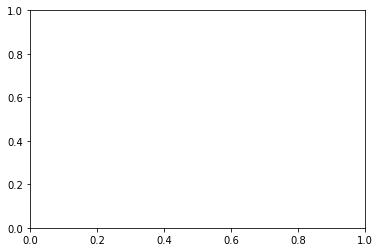

In [12]:

fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
print(f'./graphs1/loss_lr_{lr}.png')

## AUC

NameError: name 'cnn_dr' is not defined

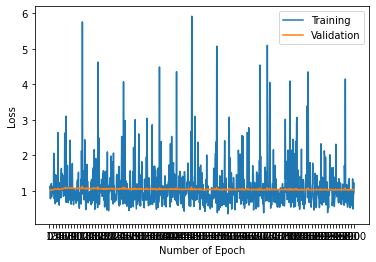

In [ ]:
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()

In [ ]:
test_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=collate_padded_batch ,num_workers=8)

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

model.load_state_dict(torch.load('saved_weights/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))

output = []
model.eval()
with torch.no_grad():

    for x, y in test_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        output.append(pred)
        
original_value_output = np.exp(output)

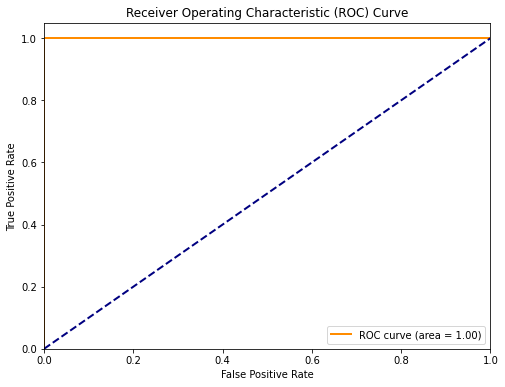

AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_auc(labels, scores):
    """
    Calculate the Area Under the Receiver Operating Characteristic Curve (AUC)
    given true binary labels and prediction scores.
    
    :param labels: List of true binary labels (0 or 1).
    :param scores: List of prediction scores (probabilities or continuous output of the model).
    :return: AUC score.
    """
    auc_score = roc_auc_score(labels, scores)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score

# Example usage
true_labels = [0, 1, 1, 0, 1]  # True binary labels
prediction_scores = [0.1, 0.4, 0.8, 0.3, 0.7]  # Prediction scores or probabilities

auc_score = calculate_auc(true_labels, prediction_scores)
print(f"AUC Score: {auc_score}")

# testing out hyper-parameters

143

In [12]:
import subprocess

def run_bash_command(command):
    """
    Runs a bash command and returns its output.
    
    :param command: The command to run as a string.
    :return: A tuple containing the command's stdout and stderr.
    """
    try:
        # Run command
        result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Return stdout and stderr
        return result.stdout, result.stderr
    except subprocess.CalledProcessError as e:
        # Handle errors in the called executable
        return e.stdout, e.stderr
    except Exception as e:
        # Handle other errors related to subprocess.run()
        return None, str(e)

# Example usage
stdout, stderr = run_bash_command('nvidia-smi')
print('STDOUT:', stdout)
print('STDERR:', stderr)

# Example of a command that generates an error
stdout, stderr = run_bash_command('ls non_existent_file')
print('STDOUT:', stdout)
print('STDERR:', stderr)

STDOUT: Sat Mar  9 15:26:12 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   36C    P0    34W / 250W |    721MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


In [14]:

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")
        
def hyper_params_test(appendix, lr, fc_dr=0,cnn_dr=0, l2=0, epoch=50):
    print('lr:', lr, '| fc_dr:',  fc_dr, '| cnn_dr:', cnn_dr, '| l2:', l2, '==='*10)
    torch.cuda.empty_cache()
    import gc; gc.collect()
    
    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    # model = Model(
    # num_classes=13,
    # num_filters=128,
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64
    # num_dense_layers=2,
    # return_logits=True,
    # dense_dropout_rate=fc_dr,
    # conv_dropout_rate=cnn_dr
    # ).to(device)
    
    model = Model(
    num_classes=13,
    num_filters=64,
    num_conv_layers=2,
    num_dense_neurons=256, # batch_size = 64
    # num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    conv_dropout_rate=cnn_dr,
    dense_dropout_rate=fc_dr
    ).to(device)

    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    
    epoch = epoch
    batch_size = 128
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch)
    # criterion = nn.MSELoss()
    criterion = masked_MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
    
    ic.disable()
    # ic.enable()
    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        
        for x, y in train_loader:
            x_batch = torch.squeeze(x, 0).to(device)
            y_batch = y.to(device)
            x_batch = x_batch.float()
            y_batch = y_batch.float()
            pred = model(x_batch.float())
            loss_train = criterion(y_batch, pred)
            ic(loss_train)
            train_batch_loss.append(loss_train)
    
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')
        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        with torch.no_grad():
            # print('test')
            for x, y in test_loader:
                x_batch = x.to(device)
                y_batch = y.to(device)
                pred = model(x_batch.float())
                loss_test = criterion(y_batch, pred)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    x = np.arange(1, epoch+1, 1)
    fig, ax = plt.subplots(facecolor = 'white')
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, fc_dr:{fc_dr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'./graphs2/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}_l2{l2}.png')
    save_to_file('trials3.txt', appendix ,epoch, lr, cnn_dr, fc_dr, l2, train_epoch_loss, test_epoch_loss)
    print(f'./graphs2/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}_l2{l2}.png')
    
    torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

In [15]:
torch.cuda.empty_cache()
import gc; gc.collect()

epoch = 250
for lr in [1e-4]:
    for fc_dr in [0.2]:
        for decay in [1e-9]:
            for cnn_dr in [0.2, 0.3, 0.4, 0.5]:
                hyper_params_test('64-2-256-2-128-log-reg', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)

# epoch = 44
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0.4]:
#             for decay in [1e-8]:
#                 hyper_params_test('final_model', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

# epoch = 50
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0, 0.2, 0.3, 0.4, 0.5]:
#             for decay in [1e-8]:
#                 hyper_params_test('64-2-256-2-128-log-reg', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

lr: 0.0001 | fc_dr: 0.2 | cnn_dr: 0 | l2: 1e-09 ==============================


  0%|          | 0/250 [00:00<?, ?it/s]

  2%|▏         | 5/250 [05:51<4:47:26, 70.40s/it]


KeyboardInterrupt: 

lr: 0.004 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:21<00:00, 55.09s/it]


lr: 0.005 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:24<00:00, 55.23s/it]


lr: 0.007 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.66s/it]


lr: 0.008 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:10<00:00, 54.54s/it]


lr: 0.0085 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:20<00:00, 55.00s/it]


lr: 0.0095 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.69s/it]


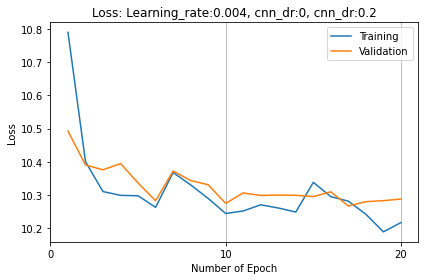

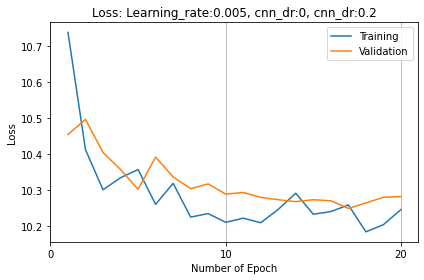

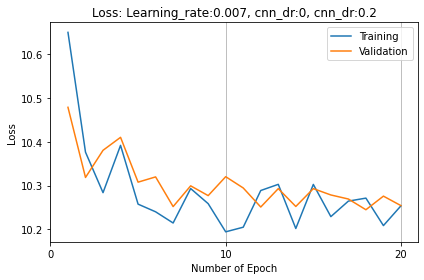

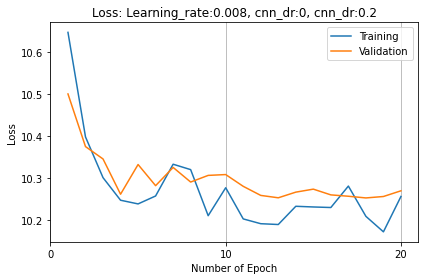

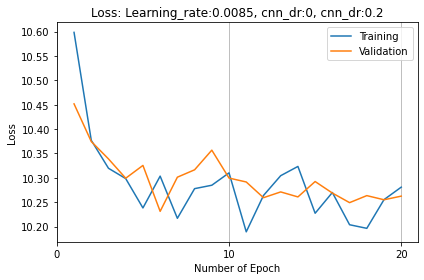

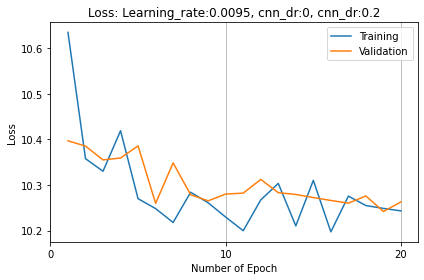

In [ ]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

In [ ]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

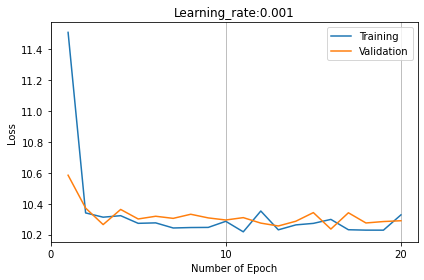

In [ ]:
#%%
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
#%%
# a = torch.zeros(1, 2, 3, 4, 5, 6)
# b = a.view(a.shape[:2], -1, a.shape[5:])
# %%
# from torchviz import make_dot
# x = torch.randn(2, 4, 56).to(device)
# m = model_torch_simple.raw_seq_model().to(device)
# y = m(x)
# make_dot(y, params=dict(list(m.named_parameters()))).render("cnn_torchviz", format="png")

# Testing

# Explanable AI

In [27]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader = DataLoader(dataset=testing_dataset, batch_size=128, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

In [28]:

save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_final1.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference
# or
# model.train()  # For further training


pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader:
        x_batch = torch.squeeze(x_test, 0).to(device)
        x_batch = x_batch.float()
        y_batch = y_test.float().to(device)
        # print(x_batch.size())
        # y_batch = torch.Tensor.float(y).to(device)
        # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
        pred = model(x_batch.float())
        pred_list.append(pred)
        target_list.append(y_batch)
        # pred = pred.unsqueeze(0)
        loss_test = criterion(y_batch, pred)
        mse_list.append(loss_test)
        # test_batch_loss.append(loss_test)
        # test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())


ic| x.shape: torch.Size([128, 256])
ic| x.shape: torch.Size([128, 13])
ic| x.shape: torch.Size([128, 256])
ic| x.shape: torch.Size([128, 13])
ic| x.shape: torch.Size([128, 256])
ic| x.shape: torch.Size([128, 13])
ic| x.shape: torch.Size([128, 256])
ic| x.shape: torch.Size([128, 13])
ic| x.shape: torch.Size([128, 256])
ic| x.shape: torch.Size([128, 13])
ic| x.shape: torch.Size([128, 256])
ic| x.shape: torch.Size([128, 13])
ic| x.shape: torch.Size([128, 256])
ic| x.shape: torch.Size([128, 13])
ic| x.shape: torch.Size([128, 256])
ic| x.shape: torch.Size([128, 13])
ic| x.shape: torch.Size([128, 256])
ic| x.shape: torch.Size([128, 13])


In [39]:
np.mean([x.detach().cpu().numpy() for x in mse_list])

0.90581405

In [22]:
test1 = test1.to(device).float()
# full_seq_input = full_seq_input[None, :]

In [26]:
len(testing_loader)

1206

In [24]:
test1[None, :]

tensor([[[[0., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 1., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [142]:
# testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

## Mic calc

In [146]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[0.73516759 0.75171939 0.9372342  1.00391215 0.57611664 0.69781489
 1.59391217 0.62171372 0.65177489 0.42724136 0.84407789 1.88967746
 1.20451594]
0.9180675616108638


In [147]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (np.exp(pred_list) - np.exp(target_list))**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[1.99657691e+01 2.19492095e-02 1.20861531e-01 1.84303685e-02
 2.18870026e+01 1.48684251e+01 1.62012543e+01 2.61311525e+01
 6.15298126e+00 2.21063227e-01 1.96245250e+00 1.24928044e+01
 9.46748127e-01]
9.30699186242598


## Ea calc

In [129]:
def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]
result = find_range_vectorized(target_list, pred_list)

In [148]:
np.exp(pred_list[0])

array([0.21734211, 0.04858502, 0.07807854, 0.01177044, 1.1826788 ,
       1.069281  , 0.02535057, 1.8139412 , 0.41462198, 0.45923612,
       0.28088352, 0.1602019 , 0.06000657], dtype=float32)

In [135]:
target_values_ =  np.exp(np.array(target_list)) # Reshape for broadcasting
quest_values_ =  np.exp(np.array(pred_list))


In [140]:
target_values_[0]

array([0.125  , 0.03   , 0.06   , 0.015  , 1.     , 0.5    , 0.01125,
       2.     , 0.25   , 0.25   , 0.25   , 0.12   , 0.03   ])

In [139]:
quest_values_[0]

array([0.20576242, 0.04286296, 0.07199533, 0.01137355, 1.0734862 ,
       1.108645  , 0.0211071 , 1.6586974 , 0.39099902, 0.42291912,
       0.2614918 , 0.12359841, 0.05220049], dtype=float32)

In [141]:
result

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       ...,
       [ True, False, False, ...,  True, False,  True],
       [ True,  True, False, ..., False,  True, False],
       [ True, False,  True, ...,  True,  True,  True]])

In [132]:
np.nanmean(result, axis=0)

array([0.59784411, 0.67247098, 0.45854063, 0.50746269, 0.7106136 ,
       0.64510779, 0.41293532, 0.56467662, 0.74626866, 0.77280265,
       0.64013267, 0.53067993, 0.69402985])

In [128]:
accuracies

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [111]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score


for i in range(result.shape[0]):
    f1 = f1_score(y_true, result[i, :])
    accuracy = accuracy_score(y_true, result[i, :])
    print(f"Model {i+1} - F1 Score: {f1}, Accuracy: {accuracy}")


NameError: name 'y_true' is not defined

In [83]:
mse_out

array([0.73516759, 0.75171939, 0.9372342 , 1.00391215, 0.57611664,
       0.69781489, 1.59391217, 0.62171372, 0.65177489, 0.42724136,
       0.84407789, 1.88967746, 1.20451594])

In [ ]:
def EA_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        ea_count = len([item for item in target_matrix[:,x] if item == True])
        ea_rate = (ea_count / len(target_matrix[:,x])) * 100
        print(drug, ea_rate)
        
def MSE_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        mse = np.mean(target_matrix[:,x])
        print(drug, mse)
        

In [50]:
pred_list

[array([[-1.5810331 , -3.1497471 , -2.631154  , -4.4764647 ,  0.07091149,
          0.1031385 , -3.8581457 ,  0.5060326 , -0.9390502 , -0.86057425,
         -1.3413523 , -2.0907176 , -2.9526634 ]], dtype=float32),
 array([[-1.6480583 , -3.399836  , -2.8341248 , -4.601759  , -0.12617642,
          0.01240166, -4.2072573 ,  0.40726072, -1.0163114 , -0.9696862 ,
         -1.4959887 , -2.3658447 , -3.0637436 ]], dtype=float32),
 array([[ 1.7333795 , -3.1506734 , -2.5390346 , -4.0204735 ,  1.4878073 ,
          1.1591023 ,  0.66148174,  2.5474248 , -0.20441489, -1.0884866 ,
         -0.44853333,  2.10234   ,  1.3385557 ]], dtype=float32),
 array([[-1.5590793 , -3.116135  , -2.565436  , -4.4179916 ,  0.10928752,
         -0.082398  , -3.7833533 ,  0.4698366 , -0.947845  , -0.8893929 ,
         -1.2869158 , -2.0749    , -2.9242966 ]], dtype=float32),
 array([[-1.4860641 , -3.2058256 , -2.6555393 , -4.432949  , -0.00669682,
         -0.09760089, -4.021046  ,  0.4431815 , -0.9616137 , -0.904213

In [45]:
np.array([])

array([], dtype=float64)

In [40]:
x = model(test1)

ic| x.shape: torch.Size([1, 256])
ic| x.shape: torch.Size([1, 13])


array([[-1.650182  , -3.6394005 , -2.891024  , -4.777055  , -0.21504799,
        -0.12163112, -4.207418  ,  0.13438919, -1.3048502 , -1.0899266 ,
        -1.9990758 , -2.3461041 , -2.9359026 ]], dtype=float32)

### Sensitivity analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assume `input_data` is your input tensor, and `feature_index` is the index of the feature to perturb
perturbation_range = np.linspace(0, 1, num=20)  # Example range of perturbation
original_value = input_data[0, feature_index].item()  # Store original value

output_changes = np.zeros((len(perturbation_range), 13))  # Store changes in outputs

for i, perturb in enumerate(perturbation_range):
    input_data[0, feature_index] = original_value + perturb  # Perturb feature value
    with torch.no_grad():
        outputs = model(input_data).numpy()  # Get model output
    output_changes[i] = outputs  # Record the change

# Reset the perturbed feature to its original value
input_data[0, feature_index] = original_value

# Example analysis for one output
plt.figure(figsize=(10, 6))
for output_index in range(13):
    plt.plot(perturbation_range, output_changes[:, output_index], label=f'Output {output_index+1}')

plt.xlabel('Perturbation')
plt.ylabel('Output Change')
plt.title('Sensitivity Analysis of Feature X on All Outputs')
plt.legend()
plt.show()


### SHAP

In [ ]:
import torch
import numpy as np

def model_wrapper(x):
    with torch.no_grad():
        # Convert the input numpy array to a PyTorch tensor
        tensor_x = torch.tensor(x, dtype=torch.float32)
        # Make a prediction with your model
        model_output = model(tensor_x)
        # Convert the prediction back to a numpy array
        return model_output.numpy()


In [ ]:
import shap

# Sample data for initialization (e.g., a batch from your training data)
X_sample = np.array([...])  # Replace with your actual numpy array

# Initialize the explainer
explainer = shap.KernelExplainer(model_wrapper, X_sample)

# Choose the instance you want to explain
X_instance = np.array([...])  # Replace with the instance in numpy array format

# Calculate SHAP values
shap_values = explainer.shap_values(X_instance)

# Plotting the SHAP values
shap.initjs()  # Initializes JavaScript visualization in Jupyter Notebooks
shap.force_plot(explainer.expected_value, shap_values, X_instance)


### Counterfactual

In [ ]:
### SHAP